## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
#if not os.path.exists('sonnets.txt'):
#    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 32
TEXT_END = -353
text = text[TEXT_START : TEXT_END]

assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join(text).lower()

assert len(text) == 96171, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))
print(tokens)

['\n', ' ', '!', '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '‘', '’']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
idx_to_token = {i: ch for i, ch in enumerate(tokens)}
# dict <char>:<index>
token_to_idx = {ch: i for i, ch in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CharRNN(nn.Module):
    def __init__(self, n_tokens, emb_size=64, hidden_size=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_tokens)

    def forward(self, x, h=None):

        x = self.emb(x)
        h_seq, h_last = self.rnn(x, h)
        logits = self.fc(h_seq)
        return logits, h_last

    def initial_state(self, batch_size, device=None):
        device = device or next(self.parameters()).device
        return torch.zeros(1, batch_size,self.hidden_size, device=device)

def get_batch(text, token_to_idx, batch_size=128, seq_len=60):

    starts = np.random.randint(0,len(text)-seq_len-1, size=batch_size)

    x = np.empty((batch_size, seq_len), dtype=np.int64)
    y = np.empty((batch_size, seq_len), dtype=np.int64)

    for i, s in enumerate(starts):
        chunk_in  = text[s:s+seq_len]
        chunk_out = text[s+1:s+seq_len + 1]
        x[i] = [token_to_idx[c] for c in chunk_in]
        y[i] = [token_to_idx[c] for c in chunk_out]

    x = torch.tensor(x, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    return x, y

num_tokens = len(tokens)
model = CharRNN(num_tokens, emb_size=64, hidden_size=256).to(device)

opt = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()

loss_history = []
steps = 1500
batch_size = 128
seq_len = 60

model.train()
for step in range(steps):
    x, y = get_batch(text, token_to_idx,batch_size=batch_size, seq_len=seq_len)
    x, y = x.to(device), y.to(device)

    logits, _ = model(x)
    loss = criterion(logits.transpose(1,2), y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_history.append(loss.item())

    if (step + 1) % 100 == 0:
        clear_output(True)
        print(f"step {step+1}/{steps} | loss = {loss.item():.4f}")

step 1500/1500 | loss = 1.0772


In [7]:
token_to_id = token_to_idx
id_to_token = idx_to_token
char_rnn = model

Plot the loss function (axis X: number of epochs, axis Y: loss function).

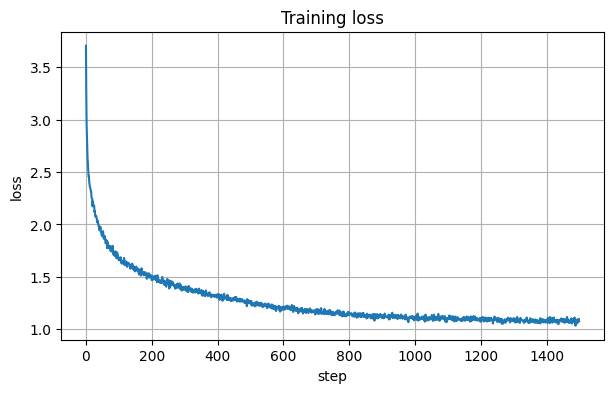

In [8]:
plt.figure(figsize=(7,4))
plt.plot(loss_history)
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training loss")
plt.grid(True)
plt.show()

char_rnn = model

In [9]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=200, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.long, device=device)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, i].unsqueeze(1), hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, -1].unsqueeze(1), hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).detach().cpu().numpy()[0, 0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [10]:
# An example of generated text.
print(generate_sample(char_rnn, seed_phrase="i am", max_length=250, temperature=0.2))

i am of all my friend and is thy beauty shall i saw my love that which it was a date,
and but when my mind, nor helet not thy shadow to me thee my heart thy part of the world and the greated;
pity is thy self respect,
the beauty shall be mine, no lon


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sample_batch(text_str, token_to_idx, batch_size=64, seq_len=50):

    starts = np.random.randint(0,len(text_str)-seq_len-1,size=batch_size)

    x = np.empty((batch_size, seq_len), dtype=np.int64)
    y = np.empty((batch_size, seq_len), dtype=np.int64)

    for i, s in enumerate(starts):
        chunk_in  = text_str[s:s+seq_len]
        chunk_out = text_str[s+1:s+seq_len+1]
        x[i] = [token_to_idx[c] for c in chunk_in]
        y[i] = [token_to_idx[c] for c in chunk_out]

    return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

class CharRNN(nn.Module):
    def __init__(self, n_tokens, emb_dim=64, hid_dim=256):
        super().__init__()
        self.hid_dim = hid_dim
        self.emb = nn.Embedding(n_tokens, emb_dim)
        self.rnn = nn.RNN(emb_dim, hid_dim,batch_first=True)
        self.fc  = nn.Linear(hid_dim, n_tokens)

    def forward(self, x, h=None):
        x = self.emb(x)
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h

    def initial_state(self, batch_size):
        return torch.zeros(1,batch_size, self.hid_dim, device=device)

class CharLSTM(nn.Module):
    def __init__(self, n_tokens, emb_dim=64, hid_dim=256):
        super().__init__()
        self.hid_dim = hid_dim
        self.emb = nn.Embedding(n_tokens, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)
        self.fc   = nn.Linear(hid_dim, n_tokens)

    def forward(self, x, state=None):
        x = self.emb(x)
        out, state = self.lstm(x, state)
        logits = self.fc(out)
        return logits, state

    def initial_state(self,batch_size):
        h0 = torch.zeros(1,batch_size, self.hid_dim, device=device)
        c0 = torch.zeros(1,batch_size, self.hid_dim, device=device)
        return (h0, c0)

def train_model(model, text_str,token_to_idx, steps=1500, batch_size=64, seq_len=50, lr=3e-3, log_every=100):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_hist = []

    model.train()
    for step in range(1, steps+1):
        x, y = sample_batch(text_str, token_to_idx, batch_size=batch_size, seq_len=seq_len)
        x, y = x.to(device), y.to(device)

        logits, _ = model(x)

        loss = criterion(logits.transpose(1,2), y)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        loss_hist.append(loss.item())

        if step % log_every == 0:
            clear_output(True)
            print(f"step {step}/{steps} | loss = {loss.item():.4f}")

    return loss_hist

num_tokens = len(tokens)

lstm_model = CharLSTM(num_tokens, emb_dim=64, hid_dim=256)
loss_lstm = train_model(lstm_model, text, token_to_idx, steps=1500, batch_size=64, seq_len=50, lr=3e-3, log_every=100)

step 1500/1500 | loss = 0.8861


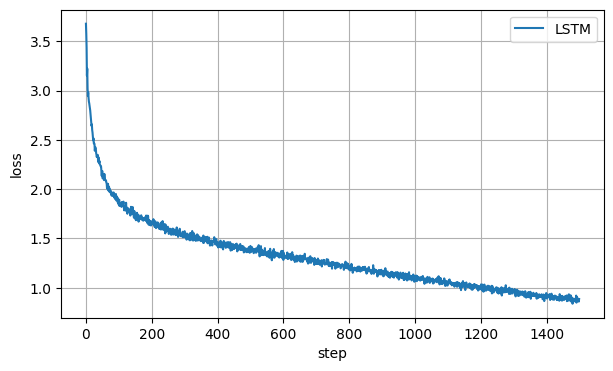

In [12]:
plt.figure(figsize=(7,4))
plt.plot(loss_lstm, label="LSTM")
plt.xlabel("step")
plt.ylabel("loss")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
print(f"RNN loss: {loss.item():.4f}")
print("LSTM loss:", loss_lstm[-1])

RNN loss: 1.0772
LSTM loss: 0.8861361742019653


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [14]:
temps = [0.1, 0.2, 0.5, 1.0, 2.0]
seed = "i am"

print("Seed:", seed.strip())

for t in temps:
    print("\n" + "="*40)
    print(f"temperature = {t}")
    print("="*40)

    try:
        sample = generate_sample(lstm_model, seed_phrase=seed, max_length=300, temperature=t)
        print(sample)
    except Exception as e:
        print("Generation error:", e)

Seed: i am

temperature = 0.1
i am forsaken;
although in their beauty of the fierce thoughts, sold cheeks her face should be forgot,
if they see than thou art as fair thou art,
and for the thing i not lacked to my soul
    to love thee afar as a drong their worth
than thou be disgrace with thee i seen,
the correct within that th

temperature = 0.2
i am not love thee light,
and praise their parts of thee,
and for this fair thou art, and therefore are you with me,
    the wide world is thine own desert,
and that me as i have seen ride;
for thou that i have seen the day of your dearest spite,
who haste most his sweet figur’d to thee:
then be not

temperature = 0.5
i am old,
gress’d in one world must be believe her beauty being make my love,
and in a woman woos, what with this give thee again,
    since when then thou dost dost that beauty’s praise,
    and night of many make me thence is my will in time
a very woed, though i feel,
not be canst not every where

temperature = 1.0
i am a wor

При увеличении temperature текст становится более разнообразным, но менее связным

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [16]:
save_path = "char_lstm_shakespeare.pth"

torch.save(lstm_model.state_dict(), save_path)
print("Saved:", save_path)

loaded_model = CharLSTM(n_tokens=len(tokens), emb_dim=64, hid_dim=256).to(device)
loaded_model.load_state_dict(torch.load(save_path, map_location=device))
loaded_model.eval()

print(generate_sample(loaded_model, seed_phrase="i am", max_length=200, temperature=0.5))

Saved: char_lstm_shakespeare.pth
i am dost thou mayst care,
and was thy shames and i am nor my poor praise shows now.
    for thee, and therefore to be as i do cure.
but all when thou feel’st it wishing,
hall dead this with thee and 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)